# Multi-class Classification of Anonymized 'Adult' Dataset - Random Forest

This notebook contains similar experiments as "Multi-class Classification of Anonymized 'Adult' Dataset - Logistic Regression". In that notebook we saw results that are similar no matter how we anonymize data. Random Forest, however shows different results and for that reason we examine that in separate notebook. 
The outline is as follows:
<ol>
    <li>In the first part we predict 'education-num' attribute based on the original data</li>
    <li>In the second part we use 3-anonymous data obtained with ARX tool
        <ul>
            <li>partial anonymization with defined hierarchies
            <li>partial anonymization without defined hierarchies
            <li>partial anonymization only for **non-countinuous** data with defined hierarchies
        </ul>
    </li>
    <li>In the last part we compare performances on all other chosen k-values (3,7,11,15,19,23)</li>
  </ol>
Anonymization done without any defined hierarchies means that all the attributes have two levels of anonymity: non-anonymous(original value) and completely anonymous(\*). Furthermore, the used partial anonymization means that it is possible to anonymize only part of a single column.

## 1. Classification of Original Data Using Random Forest

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from sklearn import metrics, preprocessing, model_selection
from sklearn.ensemble import RandomForestClassifier

c:\users\tsarcevic\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# reads the data from the csv file with specific filepath
def read_anon_data(k):
    directory = "../../data/ARX/without-hierarchies/adult_k"
    ext = ".csv"
    filepath = directory + str(k) + ext
    dataset = pd.read_csv(filepath, sep=r'\s*,\s*', na_values="*", engine='python')
    return dataset

In [3]:
# import non-anonymized dataset
dataset = read_anon_data(1)
dataset.head(10)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Non-US,<=50K
5,37,Private,284582,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Non-US,<=50K
7,52,Self-emp-not-inc,209642,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [6]:
def number_encode_features(ds):
    result = ds.copy()
    encoders = {}
    for feature in result.columns:
        if result.dtypes[feature] == np.object:
            encoders[feature] = preprocessing.LabelEncoder()
            result[feature] = encoders[feature].fit_transform(result[feature].astype(str))
    return result, encoders

In [7]:
dataset_encoded, encoders = number_encode_features(dataset)

In [8]:
# define target value
y_enc = dataset_encoded['education-num']
X_enc = dataset_encoded.drop('education-num', axis=1)

# scale
scaler = preprocessing.StandardScaler()
X_enc = pd.DataFrame(scaler.fit_transform(X_enc), columns=X_enc.columns)
X_enc.shape

(30162, 13)

In [9]:
binary_data = pd.get_dummies(dataset)

y_bin = binary_data['education-num']
X_bin = binary_data.drop('education-num', axis=1)

# scale 
X_bin = pd.DataFrame(scaler.fit_transform(X_bin), columns=X_bin.columns)

In [10]:
X_bin.columns

Index(['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week',
       'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay',
       'marital-status_Divorced', 'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'relationship_Husband'

In [11]:
# remove redundant binary data
del X_bin['sex_Male'], X_bin['income_<=50K'], X_bin['native-country_Non-US']

In [12]:
clf = RandomForestClassifier(random_state=0)

# cross validation scores 
scores = model_selection.cross_val_score(clf, X_enc, y_enc, cv=10, scoring='f1_micro')
print("F1 score (number encoded data): %0.2f (+/- %0.2f)" 
      % (scores.mean(), scores.std() * 2))
scores = model_selection.cross_val_score(clf, X_bin, y_bin, cv=model_selection.StratifiedKFold(n_splits=10, shuffle=True), scoring='f1_micro')
print("F1 score (binary attributes): %0.2f (+/- %0.2f)" 
      % (scores.mean(), scores.std() * 2))

F1 score (number encoded data): 0.58 (+/- 0.01)
F1 score (binary attributes): 0.58 (+/- 0.01)


In [13]:
predicted = model_selection.cross_val_predict(clf, X_bin, y_bin, cv=10)
f1_k1 = metrics.f1_score(y_enc, predicted, average='micro')
print(f1_k1)
print(metrics.accuracy_score(y_enc, predicted))

0.5819242755785425
0.5819242755785425


## 2. 3-anonymous data classification

We check performance of 3-anonymous data obtained with ARX tool with the following settings:
<ul>
<li>partial anonymization with defined hierarchies
<li>partial anonymization without defined hierarchies
<li>partial anonymization only for non-countinuous data with defined hierarchies

### 2.1. Partial anonymization with defined hierarchies

In [14]:
#read data
dataset = pd.read_csv("../../data/ARX/multi-class-edu/adult_k3.csv", sep=r'\s*,\s*', na_values="*", engine='python')

# preprocess
del dataset['fnlwgt']
dataset_encoded, encoders = number_encode_features(dataset)

# define target value
y = dataset_encoded['education-num']
X = dataset_encoded.drop('education-num', axis=1)

# scale
scaler = preprocessing.StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# cross validation scores 
scores = model_selection.cross_val_score(clf, X, y, cv=10, scoring='f1_micro')
print("F1 score: %0.2f (+/- %0.2f)" 
      % (scores.mean(), scores.std() * 2))

F1 score: 0.12 (+/- 0.21)


In [15]:
# prediction
predicted = model_selection.cross_val_predict(clf, X, y, cv=model_selection.StratifiedKFold(n_splits=10, shuffle=True))
f1_k3 = metrics.f1_score(y, predicted, average='micro')
print(f1_k3)

0.5418738810423712


F1 score is extremelly low. The reason can be the partial anonymization itself and generalized values that it produces. Let's just see the distribution for attribut *age* for the picture.

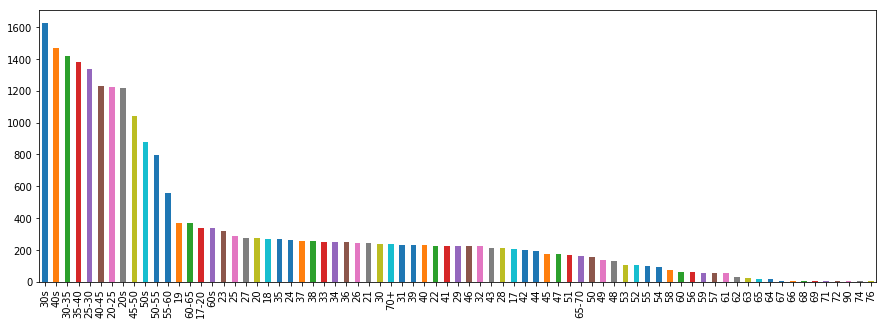

In [16]:
dataset['age'].value_counts().plot(kind='bar', figsize=(15,5))

Clearly too many values to deal with, and more importanly, it's also not quite clear how Random Forest should interpret them.

### 2.2. Partial anonymization without hierarchies

In [17]:
# import 3-anonymous dataset
k = 3
dataset = read_anon_data(k) 
dataset.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,42.0,Federal-gov,NaN,12,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40.0,United-States,<=50K
1,42.0,Federal-gov,NaN,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40.0,United-States,<=50K
2,42.0,Federal-gov,NaN,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40.0,United-States,<=50K
3,37.0,Local-gov,NaN,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40.0,United-States,<=50K
4,37.0,Local-gov,NaN,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40.0,United-States,<=50K


In [18]:
# we don't want float values
dataset['age'] = dataset['age'].astype(object)
dataset['hours-per-week'] = dataset['hours-per-week'].astype(object)

# also remove entirely anonymized 'fnlwgt'
del dataset['fnlwgt']

dataset.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,42,Federal-gov,12,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
1,42,Federal-gov,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
2,42,Federal-gov,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
3,37,Local-gov,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
4,37,Local-gov,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


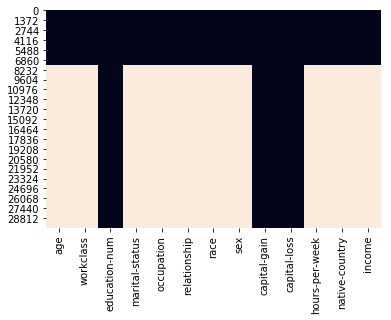

In [19]:
sns.heatmap(dataset.isnull(), cbar=False)

In [20]:
dataset_encoded, encoders = number_encode_features(dataset)

In [21]:
dataset.to_csv("../../data/ARX/without-contin-hie/adult_k3_edu_grouped.csv")

In [35]:
# define target value
y_enc = dataset_encoded['education-num']
X_enc = dataset_encoded.drop('education-num', axis=1)

# scale
scaler = preprocessing.StandardScaler()
X_enc = pd.DataFrame(scaler.fit_transform(X_enc), columns=X_enc.columns)
X_enc.shape

(30162, 12)

In [36]:
binary_data = pd.get_dummies(dataset)

y_bin = binary_data['education-num']
X_bin = binary_data.drop('education-num', axis=1)

# scale 
X_bin = pd.DataFrame(scaler.fit_transform(X_bin), columns=X_bin.columns)

In [38]:
# cross validation scores 
scores = model_selection.cross_val_score(clf, X_enc, y_enc, cv=model_selection.StratifiedKFold(n_splits=10, shuffle=False), scoring='f1_micro')
print("F1 score (number encoded data): %0.2f (+/- %0.2f)" 
      % (scores.mean(), scores.std() * 2))
scores = model_selection.cross_val_score(clf, X_bin, y_bin, cv=model_selection.StratifiedKFold(n_splits=10, shuffle=False), scoring='f1_micro')
print("F1 score (binary attributes): %0.2f (+/- %0.2f)" 
      % (scores.mean(), scores.std() * 2))

F1 score (number encoded data): 0.49 (+/- 0.01)
F1 score (binary attributes): 0.50 (+/- 0.01)


It's a huge variance so we can try to predict.

In [42]:
predicted = model_selection.cross_val_predict(clf, X_bin, y_bin, cv=model_selection.StratifiedKFold(n_splits=10, shuffle=True))
f1_k3 = metrics.f1_score(y_enc, predicted, average='micro')
print(f1_k3)

0.49651879848816394


F1 score got drastically better compared to the previous case, even though there's a lot missing values.

### 2.3. Partial anonymization of non-countinuous data with defined hierarchies

As a tradeoff between the two methods before, we can try to still keep as many values as possible but anonymize the data in such way that continuous attributes are always entirely anonymized to the same level.
*(Strong assumption is that it is imposible to do such anonymization in ARX, therefore the anonymized data will be prepared programatically: we will find the highest level of anonymity for each continuous attribute and anonymize all the values on that level according to rules. For the first try this is hardcoded.)*

In [6]:
# read the anonymized data
dataset = pd.read_csv("../../data/ARX/without-contin-hie/adult_k3.csv", sep=r'\s*,\s*', na_values="*", engine='python')
dataset.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,20s,NaN,NaN,10,NaN,NaN,NaN,NaN,Female,0,0,40,Non-US,<=50K
1,20s,NaN,NaN,7,NaN,NaN,NaN,NaN,Female,0,0,40,Non-US,<=50K
2,20s,NaN,NaN,5,NaN,NaN,NaN,NaN,Female,0,0,40,Non-US,<=50K
3,40s,NaN,NaN,15,NaN,NaN,NaN,NaN,Female,0,0,40,Non-US,<=50K
4,40s,NaN,NaN,9,NaN,NaN,NaN,NaN,Female,0,0,40,Non-US,<=50K


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 14 columns):
age               30053 non-null object
workclass         27513 non-null object
fnlwgt            0 non-null float64
education-num     30162 non-null int64
marital-status    29737 non-null object
occupation        22013 non-null object
relationship      28698 non-null object
race              27958 non-null object
sex               30053 non-null object
capital-gain      30162 non-null int64
capital-loss      30162 non-null int64
hours-per-week    30053 non-null object
native-country    30053 non-null object
income            30053 non-null object
dtypes: float64(1), int64(3), object(10)
memory usage: 2.1+ MB


There's a low percentage of rows that miss age or hours-per-week values so we will remove them, as well as columns with all missing values.

In [8]:
dataset = dataset.dropna(axis=1, how='all')
dataset = dataset.dropna(axis=0, subset=['age', 'hours-per-week'])
dataset.shape

(30053, 13)

Let's start with our anonymization. Let's first see what are the values like. We have previously already seen the distribution of age so let's now see *hours-per-week*.

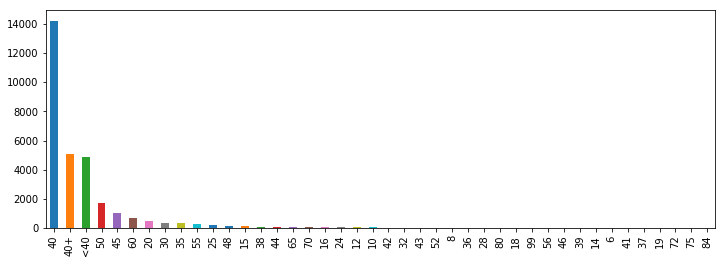

In [9]:
dataset['hours-per-week'].value_counts().plot(kind='bar', figsize=(12,4))

Those two are only originally continuous attributes. We will generalize them to the highest generalization level contained in anonymized dataset.

In [7]:
age = pd.read_csv("../../data/ARX/multi-class-edu/hie_age.csv", 
                 sep=r'\s*,\s*', na_values="*", engine='python', names=['1','2','3','4'])
age = age.dropna(axis=1, how='all')
age.head()

,1,2,3
0,17,17-20,17-20
1,18,17-20,17-20
2,19,17-20,17-20
3,20,20-25,20s
4,21,20-25,20s


In [8]:
# dictionary for generalization levels
age_levels = {level : list(age[level]) for level in age.columns}
age_levels['1'] = [str(val) for val in age_levels['1']]

In [9]:
#dictionary for conversions from level to level
#last level is not contained 
age_conversions = {}
for i,c in enumerate(age.columns):
    if i<2:
        next_level = str(i+2)
        #print("c " + c)
        #print("next " + next_level)
    # todo check if last
    else: 
        continue
    for j,val in enumerate(age_levels[c]):
        if val == "17-20" or val == "70+":
            continue
        #print(val)
        #print(age_levels[next_level][j])
        age_conversions[val] = age_levels[next_level][j]

In [10]:
hpw = pd.read_csv("../../data/ARX/hie_hpw.csv", 
                 sep=r'\s*,\s*', na_values="*", engine='python', names=['1','2','3'])
hpw = hpw.dropna(axis=1, how='all')

In [11]:
# dictionary for generalization levels
hpw_levels = {level : list(hpw[level]) for level in hpw.columns}
hpw_levels['1'] = [str(val) for val in hpw_levels['1']]

In [12]:
#dictionary for conversions from level to level
#last level is not contained 
hpw_conversions = {}
for i,c in enumerate(hpw.columns):
    if i<1:
        next_level = str(i+2)
    else: 
        continue
    for j,val in enumerate(hpw_levels[c]):
        if val == "40":
            continue
        hpw_conversions[val] = hpw_levels[next_level][j]

In [31]:
def which_level(val, att):
    if val is None:
        return None
    if att == "age":
        if str(val) in age_levels['1']:
            return 1
        elif str(val) in age_levels['2']:
            return 2
        elif str(val) in age_levels['3']:
            return 3
        else:
            return None
    elif att == "hours-per-week" or att == "hpw":
        if str(val) in hpw_levels['1']:
            return 1
        elif str(val) in hpw_levels['2']:
            return 2
        else: 
            return None
    else:
        return None

In [14]:
def generalize_to_level(level, value, att):
    if (att=="age" and level>3) or (att=="hpw" and level>2) or (att=="hours-per-week" and level>2):
        return None
    current = which_level(value, att) 
    if current==level: 
        return value
    elif current == None: 
        return None
    elif current<level: 
        # upgrade
        if att=="age":
            if value=="17-20" or value=="70+": return value
            new_value = age_conversions[value] 
        elif att=="hpw" or att=="hours-per-week":
            if value=='40': return value
            new_value = hpw_conversions[value]
        # send to next level
        return generalize_to_level(level, new_value, att) 

The terrain is prepared, now we can do our anonymization.

In [18]:
max_level = 0
for age in dataset['age']:
    if which_level(age, "age")>max_level:
        max_level = which_level(age, "age")
print(max_level)
for i,age in enumerate(dataset['age']):
    dataset['age'].at[i] = generalize_to_level(max_level, age, "age")

3


In [19]:
max_level = 0
for hpw in dataset['hours-per-week']:
    if which_level(hpw, "hours-per-week")>max_level:
        max_level = which_level(hpw, "hours-per-week")
print(max_level)
for i,hpw in enumerate(dataset['hours-per-week']):
    dataset['hours-per-week'].at[i] = generalize_to_level(max_level, hpw, "hours-per-week")

2


Those are our values now. 

In [20]:
dataset.to_csv("../../data/ARX/without-contin-hie/adult_k3_done.csv")

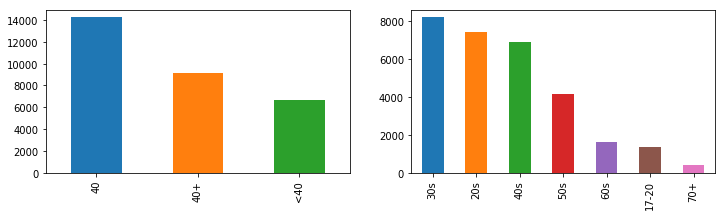

In [20]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(1,2,1)
dataset['hours-per-week'].value_counts().plot(kind='bar', axes=ax)
ax = fig.add_subplot(1,2,2)
dataset['age'].value_counts().plot(kind='bar', axes=ax)

In [21]:
dataset_encoded, encoders = number_encode_features(dataset)

In [22]:
dataset.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,20s,NaN,3,NaN,NaN,NaN,NaN,Female,0,0,40,Non-US,<=50K
1,20s,NaN,2,NaN,NaN,NaN,NaN,Female,0,0,40,Non-US,<=50K
2,20s,NaN,2,NaN,NaN,NaN,NaN,Female,0,0,40,Non-US,<=50K
3,40s,NaN,4,NaN,NaN,NaN,NaN,Female,0,0,40,Non-US,<=50K
4,40s,NaN,2,NaN,NaN,NaN,NaN,Female,0,0,40,Non-US,<=50K


In [23]:
clf = RandomForestClassifier()

In [24]:
# define target value
y = dataset_encoded['education-num']
X = dataset_encoded.drop('education-num', axis=1)

# scale
scaler = preprocessing.StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

binary_data = pd.get_dummies(dataset)

y_bin = binary_data['education-num']
X_bin = binary_data.drop('education-num', axis=1)

# scale 
X_bin = pd.DataFrame(scaler.fit_transform(X_bin), columns=X_bin.columns)

# cross validation scores 
scores = model_selection.cross_val_score(clf, X, y, cv=model_selection.StratifiedKFold(n_splits=10, shuffle=False), scoring='f1_micro')
print("F1 score (number encoded data): %0.2f (+/- %0.2f)" 
      % (scores.mean(), scores.std() * 2))
scores = model_selection.cross_val_score(clf, X_bin, y_bin, cv=model_selection.StratifiedKFold(n_splits=10, shuffle=False), scoring='f1_micro')
print("F1 score (binary attributes): %0.2f (+/- %0.2f)" 
      % (scores.mean(), scores.std() * 2))
scores = model_selection.cross_val_score(clf, X_bin, y_bin, cv=model_selection.StratifiedKFold(n_splits=10, shuffle=False), scoring='accuracy')
print("Accuracy (binary attributes): %0.2f (+/- %0.2f)" 
      % (scores.mean(), scores.std() * 2))

F1 score (number encoded data): 0.11 (+/- 0.22)
F1 score (binary attributes): 0.13 (+/- 0.27)
Accuracy (binary attributes): 0.14 (+/- 0.28)


In [25]:
prediction = model_selection.cross_val_predict(clf, X_bin, y_bin, cv=10)

In [26]:
metrics.accuracy_score(y_bin, prediction)

0.13516121518650384

Because the performance is still bad, we can conclude that any encoding of categorical data does not work fine with tree classifiers in scikit-learn. For that reason we use another classification tool - Weka - to obtain results and use them in the following parts for vizualization and comparison.

The f1 (micro average) score from Weka for database anonymized in described manner wiht k=3 is **57.2522%**.


For the original dataset the f1 score (micro) was also slightly better than scikit implementation: **59.2766%**

## Performance comparison

As stated before, f1 scores are obtained from Weka.

We preprocess the data as described in 2.3.:

In [36]:
# preprocessing
k_values = [23, 27, 31, 35, 100]
# k_values = [1, 3, 7, 11, 15, 19] #, 23, 27, 31, 35, 100]

for k in k_values:
    if k is 1 or k is 3:
        continue
        
    # import data
    dataset = pd.read_csv("../../data/ARX/without-contin-hie/adult_k" + str(k) + ".csv", 
                          sep=r'\s*,\s*', na_values="*", engine='python')
    
    # remove missings
    dataset = dataset.dropna(axis=1, how='all')
    #dataset = dataset.dropna(axis=0, subset=['age', 'hours-per-week'])
    
    # remove local anonymization for continuous attributes:
    #  age
    max_level = 0
    for age in dataset['age']:
        if not(which_level(age, "age") is None) and which_level(age, "age") > max_level:
            max_level = which_level(age, "age")
    for i, age in enumerate(dataset['age']):
        dataset['age'].at[i] = generalize_to_level(max_level, age, "age")
    #  hours-per-week
    max_level = 0
    for hpw in dataset['hours-per-week']:
        if not(which_level(hpw, "hpw") is None) and which_level(hpw, "hours-per-week") > max_level:
            max_level = which_level(hpw, "hours-per-week")
    for i, hpw in enumerate(dataset['hours-per-week']):
        dataset['hours-per-week'].at[i] = generalize_to_level(max_level, hpw, "hours-per-week")
    
    # save preprocessed dataset
    dataset.to_csv("../../data/ARX/without-contin-hie/adult_k" + str(k) + "_done.csv", 
                   index=False)

In [51]:
k_values = [1, 3, 7, 11, 15, 19, 23, 27, 31, 35, 100]
# read f1 scores obtained using Weka 
with open("../../data/ARX/without-contin-hie/f1_scores_Random_Forest_Weka.txt") as f:
    lines = f.readlines()
f1_scores = [float(score.rstrip('\n')) for score in lines]

Text(0.5,0,'k')

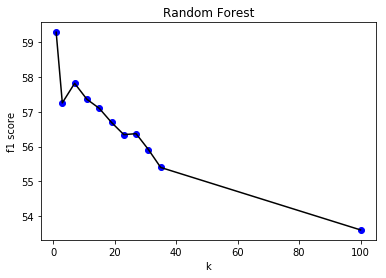

In [52]:
# visualize how f1 score depends on k
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Random Forest')

plt.plot(k_values, f1_scores, 'bo', k_values, f1_scores, 'k')
plt.ylabel('f1 score')
plt.xlabel('k')

In [81]:
# pickle f1 scores 
outfile = open('../../data/ARX/without-hierarchies/RF_f1_scores', 'wb')
pickle.dump(f1_scores, outfile)
outfile.close()

After numerous experiments, those results make some sense. 

Experiments:
<ol>
    <li>Well defined attribute hierarcies for anonymization, global anonymization (entire column anonymized to the same anonymization level) and RandomForestClassifier from scikit-learn as a classifier.
        <ul>
            <li>Results from paper are not obtained by global anonymization, so there's no relevance.</li>
        </ul>
    </li>
    <li>Well defined attribute hierarchies for anonymization, local anonymization (a single column contains values anonymized to different anonymization levels
        <ul>
            <li>Anonymized dataset results with columns containing a large number different values due to local anonymization</li>
            <li>Mixing continuous and ordinal/categorical values in a single attribute</li>
            <li>F1 score is extremely low</li>
        </ul>
    </li>
    <li>Hierarchies for attributes not defined at all, local anonymization 
        <ul>
            <li>Already for small k (k=3) results with dataset with around 70% percent completely anonymized rows, i.e. rows with all missing values. 
        </ul>
    </li>
    <li>Hierarchies defined fairly well, local anonymization performed for categorical data, global anonymization performed on continuous data, scikit's RandomForestClassifier used for classification.
        <ul>
            <li>Bad f1 score for some reason (probably due to lack of good implementation for categorical data for this classifier)
        </ul>
    </li>
    <li>Hierarchies defined fairly well, local anonymization performed for categorical data, global anonymization performed on continuous data, scikit's RandomForestClassifier used for classification.
        <ul>
            <li>Results slightly better than in paper</li>
            <li>Also behavior is different - f1 lowering instead of growing</li>
        </ul>
    </li>
</ol>

The main problem with reconstucting the results were the unknown key configurations, for example:
<ul>
    <li>It's unknown how exaclty hierarchies for anonymization were defined
    <li>The same anonymization tool not available
    <li>Unknown tool/library for classification task
    <li>Unknown how datasets were preprocessed
</ul>